# Exercise 7
## Céline Budding && Dorothea Müller 

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

%matplotlib inline

## 1. The 10-armed bandit

### 1.

In [2]:
reward_prob = np.random.uniform(0, 0.9, 10)
reward_prob

array([0.51276861, 0.01205066, 0.85922013, 0.68891216, 0.31992342,
       0.67066159, 0.86581735, 0.08993092, 0.45074185, 0.20068799])

### 2.

In [3]:
def generate_reward(reward_prob, lever_numbers):
    rewards = np.zeros(len(lever_numbers))
    for i, lever_number in enumerate(lever_numbers):
        if np.random.random() > reward_prob[lever_number]:
            rewards[i] = 0
        else:
            rewards[i] = 1
    return rewards

In [4]:
# Testing.
n = 10000
received_rewards = np.zeros(len(reward_prob))
for i in range(n):
    received_rewards += generate_reward(reward_prob, np.arange(0, 10))
received_rewards/=n

In [5]:
received_rewards

array([0.5099, 0.0127, 0.8611, 0.6889, 0.3224, 0.6792, 0.8666, 0.0876,
       0.4588, 0.1949])

### 3.

In [6]:
# def update_q(reward_prob, q, eta = 0.01):
#     delta_q = eta * (generate_reward(reward_prob, np.arange(0, len(reward_prob))) - q)
#     q = q + delta_q
#     return q

In [7]:
def update_q(reward, pos, q, eta = 0.01):
    delta_q = eta * (reward - q[pos])
    q[pos] += delta_q
    return q

In [8]:
q = np.zeros(len(reward_prob))
q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
for i in range(n):
    # Pulling the levers at all positions.
    q = update_q(reward_prob, np.arange(len(q)), q)
q

array([0.51276861, 0.01205066, 0.85922013, 0.68891216, 0.31992342,
       0.67066159, 0.86581735, 0.08993092, 0.45074185, 0.20068799])

### 4.

In [10]:
def eps_greedy(q, eps):
    """Return lever(s) to be pressed, q value of chosen lever, largest q value."""
    if np.random.random() < 1-eps:
        # Get all the maxima.
        pos = np.argwhere(q == np.amax(q)).flatten()
        val = np.take(q, pos, 0)[0]
        largest_val = val
    else:
        pos = np.random.randint(0, len(q))
        val = q[pos]
        largest_val = q[np.argmax(q)]
        pos = np.array([pos])
        
    return [pos, val, largest_val]

### 5.

In [11]:
def pure_greedy_seq():
    q = np.zeros(len(reward_prob))

    n = 1000
    expected_reward = np.zeros(n)

    for i in range(n):
        levers = eps_greedy(q, 0)
        pos = levers[0]
        reward = generate_reward(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
    
    return expected_reward

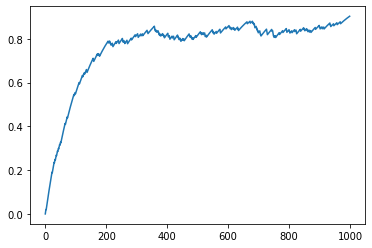

In [12]:
expected_reward = pure_greedy_seq()
plt.plot(expected_reward)

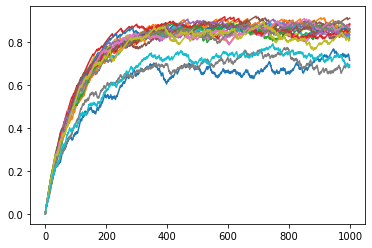

In [13]:
for i in range(20):
    expected_reward = pure_greedy_seq()
    plt.plot(expected_reward)

**Does the agent
consistently identify the levers with the largest reward probabilities?**

No.

### 6.

In [14]:
def get_seq(eps):
    q = np.zeros(len(reward_prob))

    n = 1000
    expected_reward = np.zeros(n)
    max_reward = np.zeros(n)

    for i in range(n):
        levers = eps_greedy(q, eps)
        pos = levers[0]
        reward = generate_reward(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
        max_reward[i] = levers[2]
    
    return expected_reward, max_reward

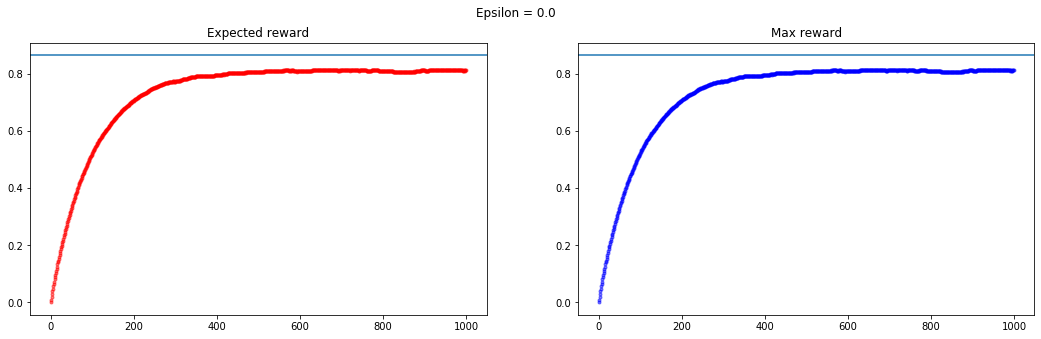

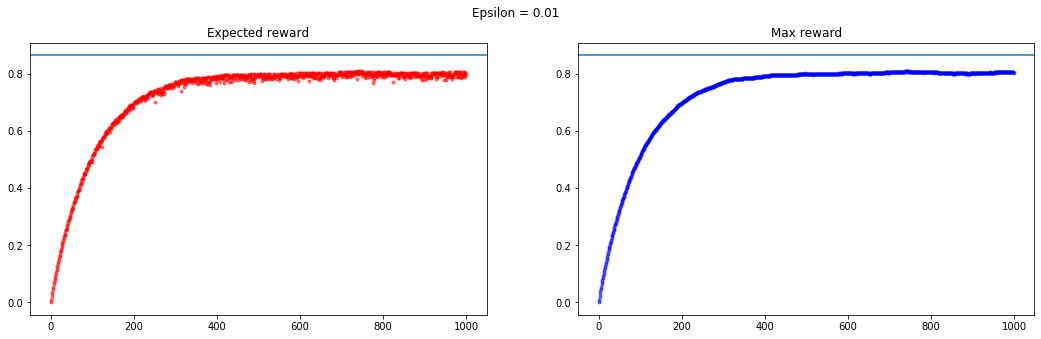

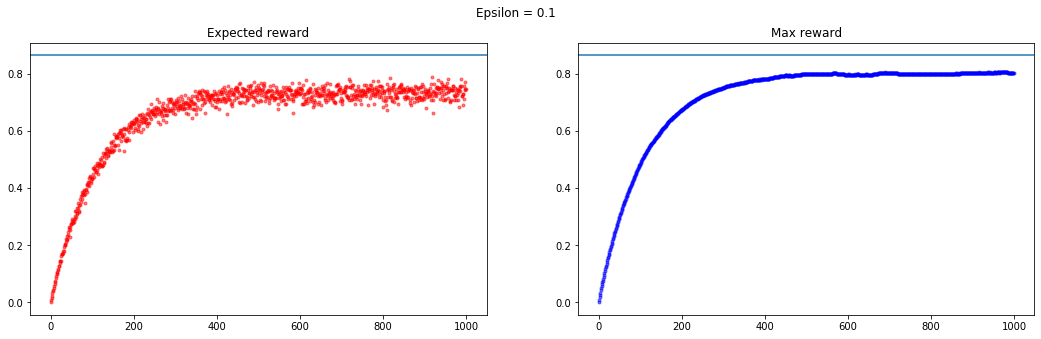

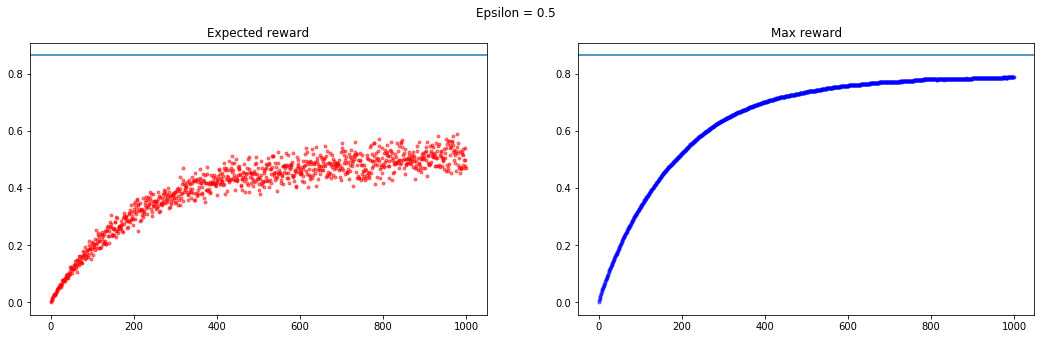

In [15]:
all_eps = [0.0, 0.01, 0.1, 0.5]

expected_reward = np.zeros(1000)
max_reward = np.zeros(1000)
lifes = 100

for eps in all_eps:
    for life in range(lifes):
        expected_reward_one_life, max_reward_one_life = get_seq(eps)
        expected_reward += expected_reward_one_life
        max_reward += max_reward_one_life
        
    expected_reward/= lifes
    max_reward/= lifes
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 5))
    axs[0].plot(expected_reward, 'ro', markersize=3, alpha = 0.5)
    axs[0].set_title("Expected reward")
    axs[0].axhline(np.max(reward_prob))
    axs[1].plot(max_reward, 'bo', markersize=3, alpha = 0.5)
    axs[1].set_title("Max reward")
    axs[1].axhline(np.max(reward_prob))

    plt.suptitle(f"Epsilon = {eps}")
    plt.show()

**Why the looks?**

We need more time to converge for larger epsilon as the chance for taking a random negative action is higher. This is why it makes sense to adapt the epsilon to a lower value for lower lifetimes. 

### 7.

In [16]:
def softmax(q, beta):
    """Return position of lever, value at this position and maximum q-value."""
    p = np.exp(beta * q)/np.sum(np.exp(beta * q))
    p_cum = np.cumsum(p)
    
    rand_el = np.random.random()
    pos =  np.argwhere(p_cum > rand_el)[0]
    val = q[pos][0]
    max_val = np.max(q)
    
    return [pos, val, max_val]

In [17]:
# Testing.
q = np.array([0.2, 0.5, 0.3])
softmax(q, 1)

[array([2]), 0.3, 0.5]

In [18]:
## TODO: combine to one fn get_seq where you pass on the policy and **kwargs to it (this one and above)
# This also goes for n = 5000... but hey.

In [19]:
def get_seq(beta):
    q = np.zeros(len(reward_prob))

    n = 5000
    expected_reward = np.zeros(n)
    max_reward = np.zeros(n)

    for i in range(n):
        levers = softmax(q, beta)
        pos = levers[0]
        reward = generate_reward(reward_prob, pos)
        q = update_q(reward, pos, q)

        expected_reward[i] = levers[1]
        max_reward[i] = levers[2]
    
    return expected_reward, max_reward

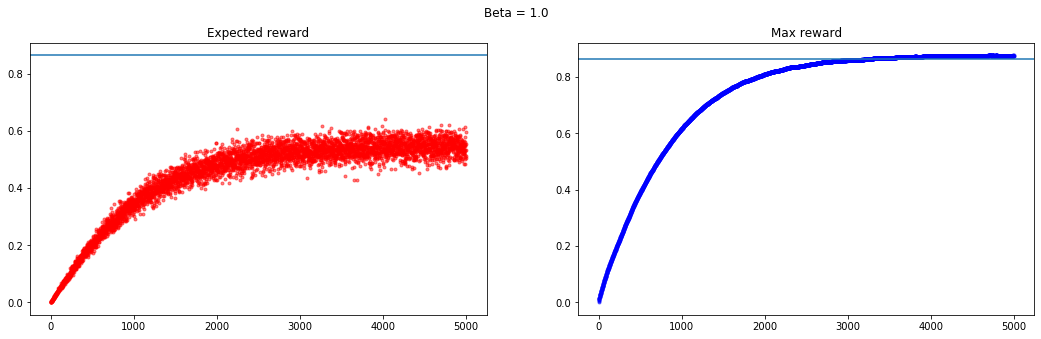

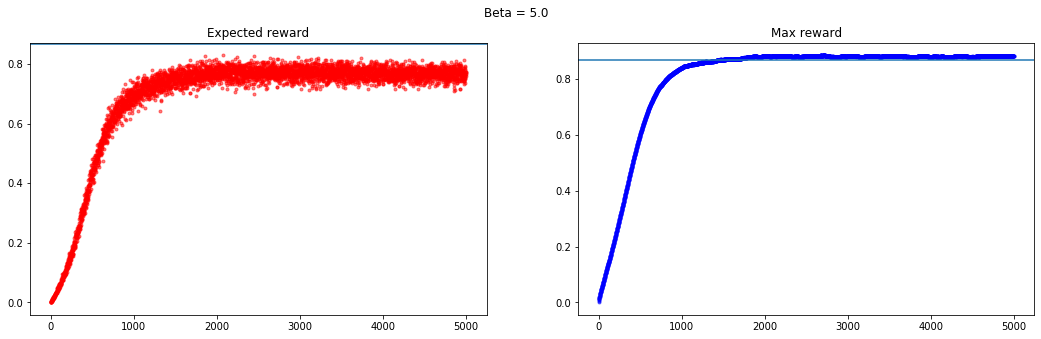

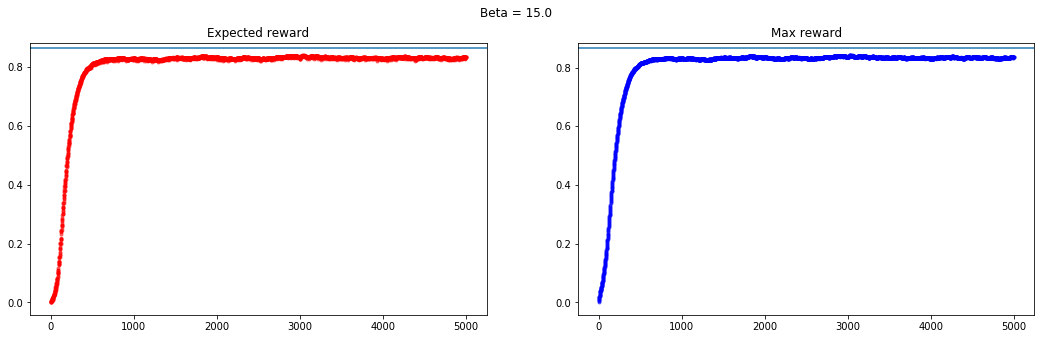

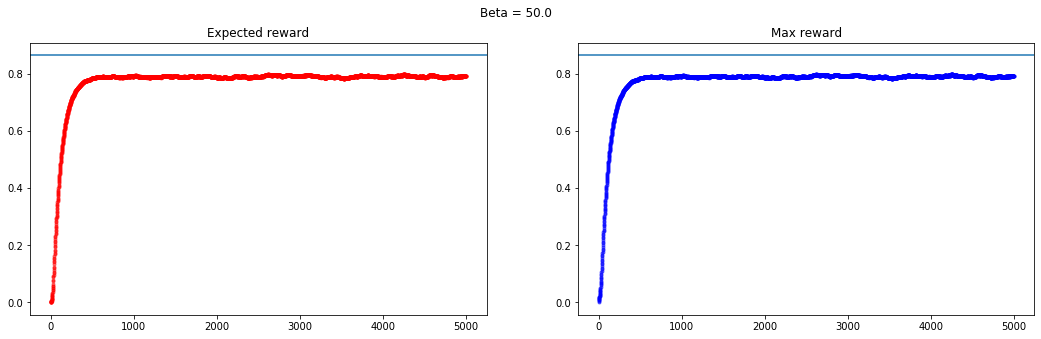

In [21]:
all_betas = [1.0, 5.0, 15.0, 50.0]

expected_reward = np.zeros(5000)
max_reward = np.zeros(5000)
lifes = 100

for beta in all_betas:
    for life in range(lifes):
        expected_reward_one_life, max_reward_one_life = get_seq(beta)
        expected_reward += expected_reward_one_life
        max_reward += max_reward_one_life
        
    expected_reward/= lifes
    max_reward/= lifes
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 5))
    axs[0].plot(expected_reward, 'ro', markersize=3, alpha = 0.5)
    axs[0].set_title("Expected reward")
    axs[0].axhline(np.max(reward_prob))
    axs[1].plot(max_reward, 'bo', markersize=3, alpha = 0.5)
    axs[1].set_title("Max reward")
    axs[1].axhline(np.max(reward_prob))

    plt.suptitle(f"Beta = {beta}")
    plt.show()

**Do the results of SoftMax show any improvements compared to the epsilon-greedy policies?** 

Here we have to be careful as the number of iterations is chosen differently for the epsilon-greedy policy than for the softmax policy. However, ...
## TODO

**How does the parameter β relate to the exploration/exploitation-balance?**
A high beta corresponds to more exploitation as for beta = 50 the reward is lower than for beta = 15. However, we quickly reach a value close to the optimum as we are converging quicker than for low beta where the exploration is higher/takes longer, so for short life times a high beta would be recommended.

**And once again explain why for each β the two curves (expected reward & largest Q-value) look the way they do.**
See exploration and exploitation above. For a high beta, the difference in the probabilities for Q get larger than for low beta values. This is why for low q values the maximum reward that we find is also lower in the beginning, as states with low reward probability are still explored with relatively high probability. However, in the long run, lower beta does converge closer to the maximum reward expectation since all states have been visited so the one with the highest reward probability will definitely be found. 